# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_nopercolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.xception.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv2d_3', 'block14_sepconv1', 'block14_sepconv2']
    LAST_LAYER = 'block14_sepconv2'
    PREPROCESSING = tf.keras.applications.xception.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.7907 - accuracy: 0.7362

947/947 [==============================] - 5038s 5s/step - loss: 0.7907 - accuracy: 0.7362 - val_loss: 0.7294 - val_accuracy: 0.7592
Epoch 2/200
947/947 [==============================] - 4584s 5s/step - loss: 0.6669 - accuracy: 0.7699 - val_loss: 0.7631 - val_accuracy: 0.7551
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6132 - accuracy: 0.7865

947/947 [==============================] - 4679s 5s/step - loss: 0.6132 - accuracy: 0.7865 - val_loss: 0.6301 - val_accuracy: 0.7855
Epoch 4/200
947/947 [==============================] - 4561s 5s/step - loss: 0.5800 - accuracy: 0.7962 - val_loss: 0.8180 - val_accuracy: 0.7419
Epoch 5/200
947/947 [==============================] - 4706s 5s/step - loss: 0.5546 - accuracy: 0.8049 - val_loss: 0.8026 - val_accuracy: 0.7531
Epoch 6/200
947/947 [==============================] - 4603s 5s/step - loss: 0.5266 - accuracy: 0.8114 - val_loss: 0.7763 - val_accuracy: 0.7619
Epoch 7/200
947/947 [==============================] - 4751s 5s/step - loss: 0.5069 - accuracy: 0.8198 - val_loss: 0.6437 - val_accuracy: 0.7896
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.4811 - accuracy: 0.8301

947/947 [==============================] - 5163s 5s/step - loss: 0.4811 - accuracy: 0.8301 - val_loss: 0.6246 - val_accuracy: 0.8006
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 0.4635 - accuracy: 0.8343

947/947 [==============================] - 4763s 5s/step - loss: 0.4635 - accuracy: 0.8343 - val_loss: 0.5319 - val_accuracy: 0.8164
Epoch 10/200
947/947 [==============================] - 4594s 5s/step - loss: 0.4420 - accuracy: 0.8395 - val_loss: 0.5458 - val_accuracy: 0.8111
Epoch 11/200
947/947 [==============================] - 4608s 5s/step - loss: 0.4340 - accuracy: 0.8447 - val_loss: 1.2471 - val_accuracy: 0.7553
Epoch 12/200
947/947 [==============================] - 4589s 5s/step - loss: 0.4142 - accuracy: 0.8527 - val_loss: 0.5610 - val_accuracy: 0.8080
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.8574

947/947 [==============================] - 4711s 5s/step - loss: 0.3980 - accuracy: 0.8574 - val_loss: 0.4928 - val_accuracy: 0.8309
Epoch 14/200
947/947 [==============================] - 4558s 5s/step - loss: 0.3847 - accuracy: 0.8618 - val_loss: 0.6104 - val_accuracy: 0.7970
Epoch 15/200
947/947 [==============================] - 4692s 5s/step - loss: 0.3656 - accuracy: 0.8695 - val_loss: 0.4988 - val_accuracy: 0.8386
Epoch 16/200
947/947 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.8725

947/947 [==============================] - 4962s 5s/step - loss: 0.3559 - accuracy: 0.8725 - val_loss: 0.4820 - val_accuracy: 0.8386
Epoch 17/200
947/947 [==============================] - 4648s 5s/step - loss: 0.3401 - accuracy: 0.8785 - val_loss: 0.6615 - val_accuracy: 0.8025
Epoch 18/200
947/947 [==============================] - 4652s 5s/step - loss: 0.3341 - accuracy: 0.8793 - val_loss: 0.4866 - val_accuracy: 0.8397
Epoch 19/200
947/947 [==============================] - 6640s 7s/step - loss: 0.3167 - accuracy: 0.8849 - val_loss: 0.5327 - val_accuracy: 0.8408
Epoch 20/200
947/947 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8897

947/947 [==============================] - 8924s 9s/step - loss: 0.3038 - accuracy: 0.8897 - val_loss: 0.4816 - val_accuracy: 0.8374
Epoch 21/200
947/947 [==============================] - 7717s 8s/step - loss: 0.2893 - accuracy: 0.8948 - val_loss: 0.5171 - val_accuracy: 0.8394
Epoch 22/200
947/947 [==============================] - ETA: 0s - loss: 0.2867 - accuracy: 0.8967

947/947 [==============================] - 6200s 7s/step - loss: 0.2867 - accuracy: 0.8967 - val_loss: 0.4622 - val_accuracy: 0.8511
Epoch 23/200
947/947 [==============================] - ETA: 0s - loss: 0.2683 - accuracy: 0.9008

947/947 [==============================] - 4864s 5s/step - loss: 0.2683 - accuracy: 0.9008 - val_loss: 0.4596 - val_accuracy: 0.8537
Epoch 24/200
947/947 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.9052

947/947 [==============================] - 4811s 5s/step - loss: 0.2592 - accuracy: 0.9052 - val_loss: 0.4306 - val_accuracy: 0.8581
Epoch 25/200
947/947 [==============================] - 4590s 5s/step - loss: 0.2463 - accuracy: 0.9083 - val_loss: 0.5666 - val_accuracy: 0.8423
Epoch 26/200
947/947 [==============================] - 4569s 5s/step - loss: 0.2364 - accuracy: 0.9138 - val_loss: 0.4819 - val_accuracy: 0.8562
Epoch 27/200
947/947 [==============================] - 4562s 5s/step - loss: 0.2290 - accuracy: 0.9150 - val_loss: 0.5197 - val_accuracy: 0.8542
Epoch 28/200
947/947 [==============================] - 4616s 5s/step - loss: 0.2204 - accuracy: 0.9212 - val_loss: 0.5465 - val_accuracy: 0.8451
Epoch 29/200
947/947 [==============================] - 4637s 5s/step - loss: 0.2093 - accuracy: 0.9232 - val_loss: 0.4714 - val_accuracy: 0.8616
Epoch 30/200
947/947 [==============================] - 4626s 5s/step - loss: 0.2027 - accuracy: 0.9260 - val_loss: 0.5193 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 446s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9683139519020361,
 'basal cell carcinoma': 0.9858114942938501,
 'dermatofibroma': 0.9789287422285987,
 'melanoma': 0.9417212698013722,
 'nevus': 0.9679892124706768,
 'pigmented benign keratosis': 0.985034432185032,
 'seborrheic keratosis': 0.9626995914674759,
 'solar lentigo': 0.9743950263032042,
 'squamous cell carcinoma': 0.9788103089685496,
 'vascular lesion': 0.9999245965917659}

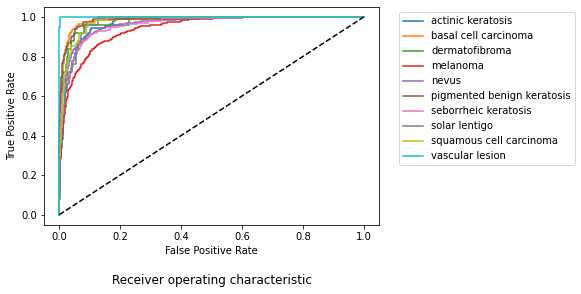

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

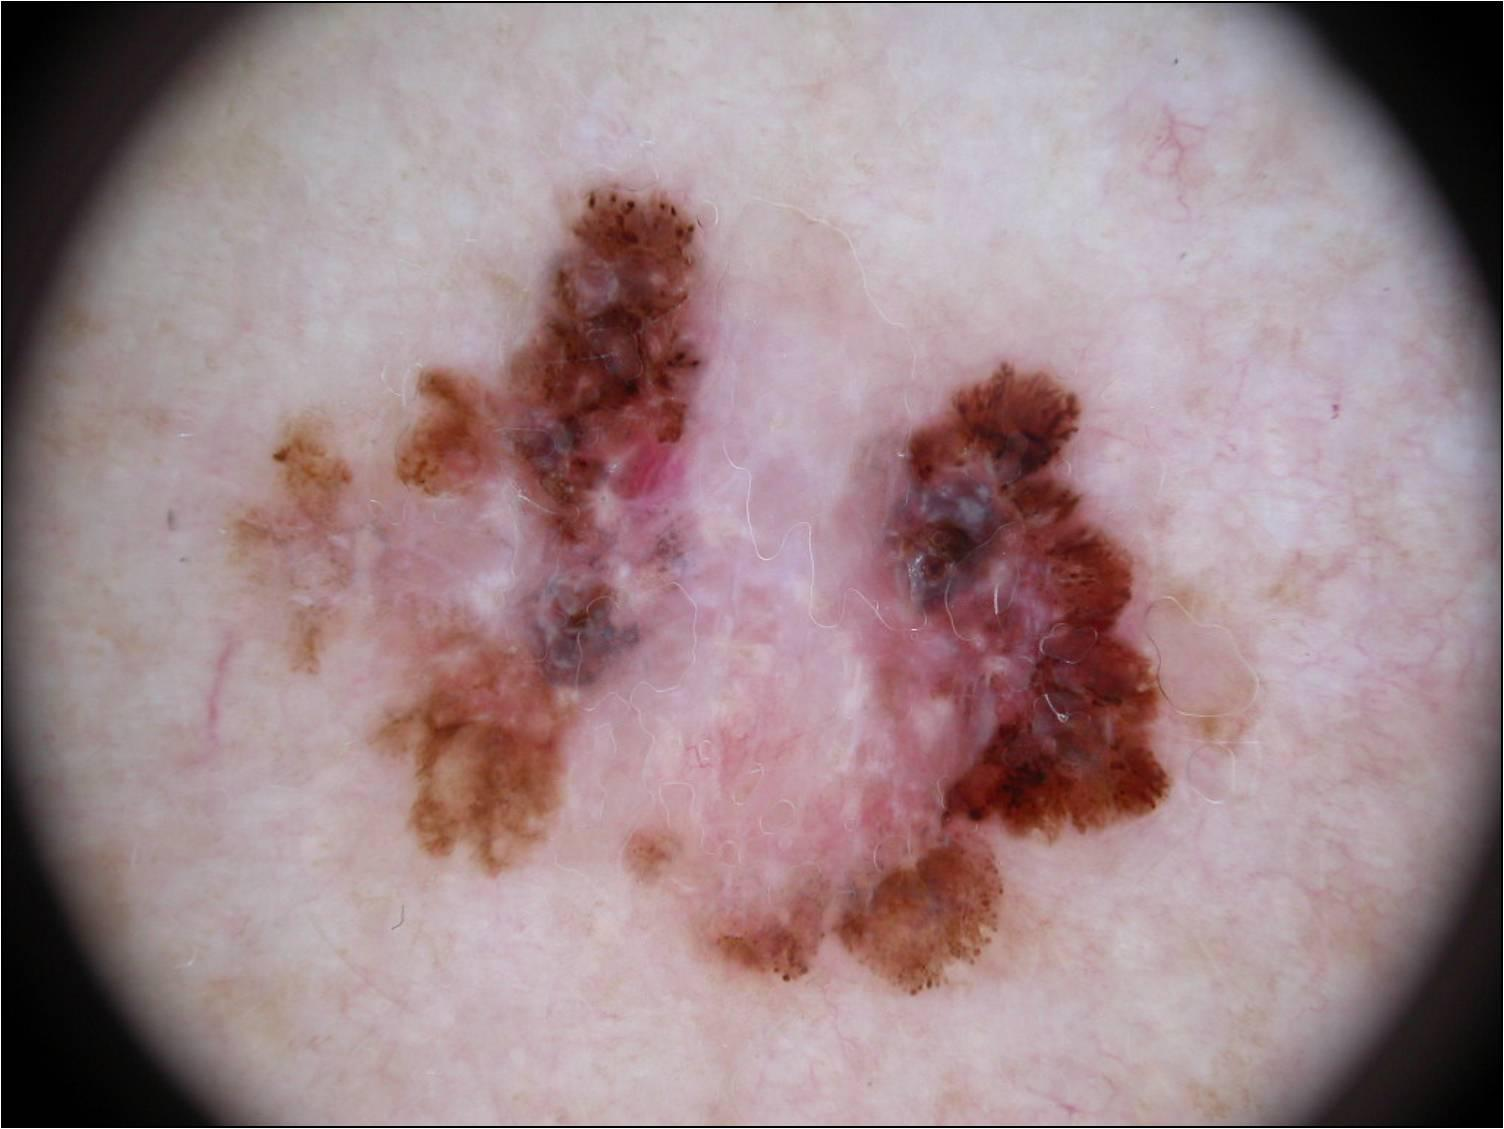

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

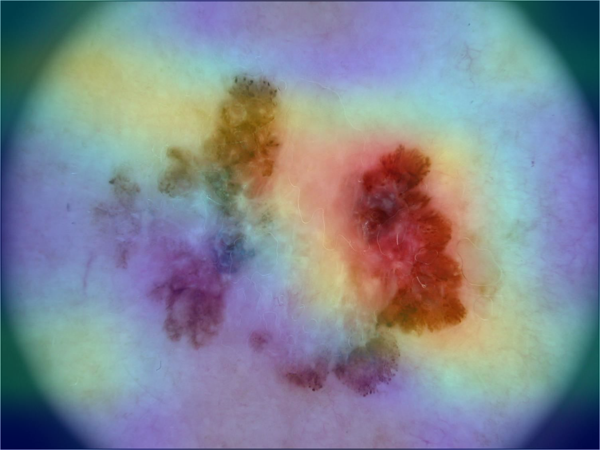

In [23]:
display_gradcam(melanoma_im_path, heatmap)